In [30]:
from spellchecker import SpellChecker
from spacy.matcher.matcher import Matcher # NVB, NAJ, NPV
from spacy.symbols import nsubj, nsubjpass, dobj, conj, pobj, prep, amod, NOUN, VERB, ADJ, ADV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import nltk
import spacy
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

[nltk_data] Downloading package punkt to /Users/kyuliew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kyuliew/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kyuliew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



    Features to extract:
    AWL – Average Word Length
    ASL – Average Sentence Length
    NOW – Number of Words
    NVB – Number of Verbs
    NAJ – Number of Adjectives
    NPV – Number of Passive Voice Constructions
    NST – Number of Sentences
    CDV – Content Diversity = |V| / #tokens (ignore punctuation & stopwords)
    NTP – Number of Typos
    TPR – Typo Ratio


In [12]:
df = pd.read_excel("data/original/restaurant_reviews-v2-1.xlsx")

In [13]:
df.head()

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,Tikka Shack,Great food and great atmosphere! The chicken t...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tikka Shack,I had heard good things about Tikka Shak so I ...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tikka Shack,I was driving by tikka shack one day and decid...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tikka Shack,Tikka Shack had the most modern and up-to-date...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India Palace\nIndian\nRestaurant,Today is the third time I've come to India Pal...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Perform Sentence and Word tokenization to prepare for feature extraction

In [14]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+\'?\w+|\w+')
spell = SpellChecker()
parts_speech = spacy.load("en_core_web_sm")

In [15]:
df['tokenized_sents'] = df.apply(lambda row: sent_tokenize(row['Review']), axis=1)

In [16]:

df['tokenized_words'] = df.apply(lambda row: tokenizer.tokenize(row['Review']), axis=1)

In [17]:
"""
  Performs part of speech tagging and lemmatization to extract and compute the
  number of verbs, adjectives, and passive voice construction in the review.
  Also computes the content diversity of the review by getting the number of unique
  tokens as the vocabulary size and dividing it by the number of tokens.
  Returns a series object to be applied into the dataframe.
"""
def tokenize_speech(row):
  tagged_sentences = []
  total_verbs = 0
  total_adj = 0
  total_passive = 0
  tokens = []

  for sentence in row:
    tagged_sentences.append(parts_speech(sentence))

  for tagged_sent in tagged_sentences:

    for token in tagged_sent:
        if token.is_alpha and not token.is_stop and not token.is_punct:
          tokens.append(token.lemma_)
        if token.pos_ == "VERB":
          total_verbs += 1
        if token.pos_ == "ADJ":
          total_adj += 1
        if token.dep_ in ("nsubjpass", "auxpass", "csubjpass"):
          total_passive += 1

  unique_vocab = len(set(tokens))

  content_diversity = round(unique_vocab / len(tokens), 2)

  # print(f'Content Diversity: {content_diversity}')
  # print(f'Total Verbs: {total_verbs}')
  # print(f'Total Adjectives: {total_adj}')
  # print(f'Total Passive Voice Construction: {total_passive}')

  return pd.Series([content_diversity, total_verbs, total_adj, total_passive], index=['CDV', 'NVB', 'NAJ', 'NPV'])

In [18]:
"""
  Tokenizes every sentence in the row to get the sentence length and spells check
  all alphabetic words.
  Computes the total sentence length, average sentence length, number of typos,
  and typo ratio of the review.
  Returns series object to be applied to the dataframe.
"""
def tokenize_sentences(row):
  # NST, ASL, NTP, TPR
  total_sentence_length = 0
  words_sc = []

  for sentence in row:
    words = tokenizer.tokenize(sentence.lower())
    total_sentence_length += len(words)

    for word in words:
      if word.isalpha():
        words_sc.append(word)

  # print(f'Length of words dict: {len(words_dict)}')

  spell_check = spell.unknown(words_sc)

  num_typos = len(spell_check)

  typo_ratio = round(num_typos / total_sentence_length, 2)

  avg_sentence_length = round(total_sentence_length / len(row), 2)

  # print(f'Number of typos: {num_typos}')

  # print(f'Typo ratio: {typo_ratio}')

  # print(f'Total Sentence Length: {total_sentence_length}')

  # print(f'Avg Sentence Length: {avg_sentence_length}')

  return pd.Series([total_sentence_length, avg_sentence_length, num_typos, typo_ratio], index=['NST', 'ASL', 'NTP', 'TPR'])

In [19]:
"""
  Get the word count and average word length.
  Returns a series object to be applied to the dataframe.
"""
def tokenize_words(row):

  # print(f'Word Count: {len(row)}')

  total_word_length = 0

  for word in row:
    total_word_length += len(word)

  # print(f'Total Word Length: {total_word_length}')

  word_count = len(row)

  avg_word_length = round(total_word_length / len(row), 2)

  # print(f'Avg Word Length: {avg_word_length:.2f}')

  return pd.Series([avg_word_length, word_count], index=['AWL', 'NOW'])

# Perform feature extraction

In [20]:
df[['CDV', 'NVB', 'NAJ', 'NPV']] = df['tokenized_sents'].apply(lambda row: tokenize_speech(row))

In [21]:
df[['NST', 'ASL', 'NTP', 'TPR']] = df['tokenized_sents'].apply(lambda row: tokenize_sentences(row))

In [22]:
df[["AWL", "NOW"]] = df['tokenized_words'].apply(lambda row: tokenize_words(row))

# Clean-up and checking results

In [23]:
df = df.drop(["Review","Restaurant", "positive=1/negative=0", "tokenized_sents", "tokenized_words"], axis=1)

In [24]:
df[['NOW', 'NVB', 'NAJ', 'NPV', 'NTP']] = df[['NOW', 'NVB', 'NAJ', 'NPV', 'NTP']].astype(int)

In [25]:
df

,Real=1/Fake=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,0,4.67,16.60,83,12,6,0,83.0,0.89,5,0.06
1,0,4.07,18.17,109,15,8,2,109.0,0.95,4,0.04
2,0,3.61,16.00,112,15,4,4,112.0,0.86,1,0.01
3,0,4.39,15.25,61,9,7,0,61.0,0.92,1,0.02
4,0,4.50,14.80,74,10,9,0,74.0,0.90,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
255,0,4.12,10.40,52,4,4,0,52.0,0.94,2,0.04
256,1,4.30,18.00,90,9,7,2,90.0,0.97,0,0.00
257,0,4.52,11.83,71,7,9,0,71.0,0.85,2,0.03
258,1,4.67,18.00,54,5,6,0,54.0,0.90,4,0.07


# Correlation Matrix

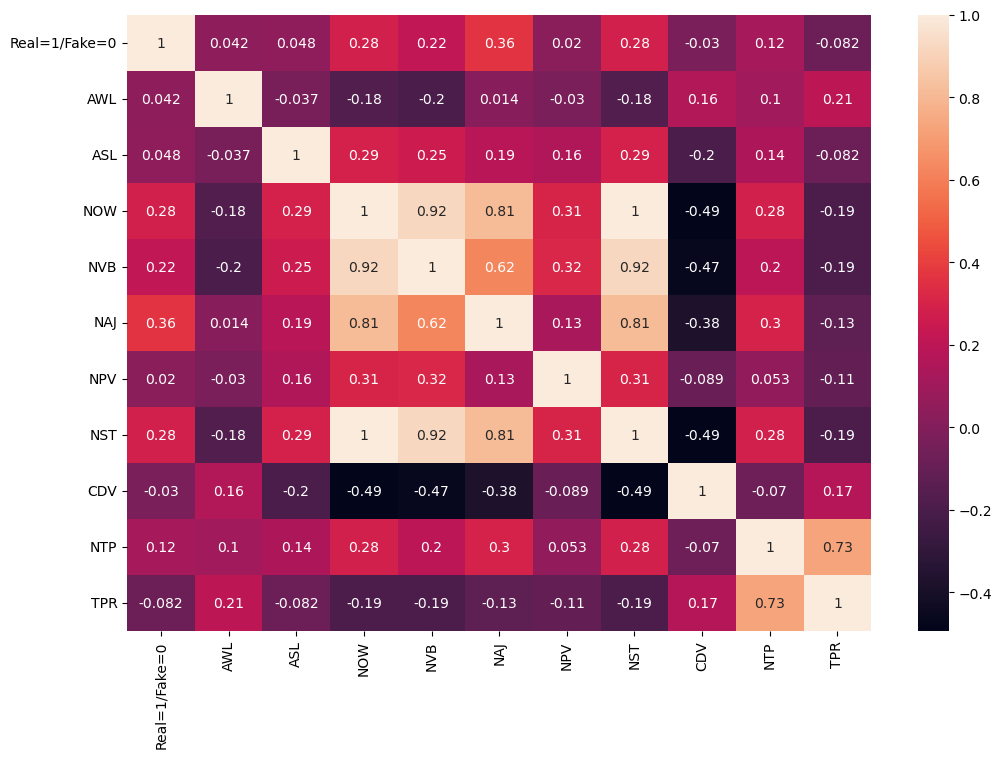

In [26]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="rocket", annot=True)
plt.show()

In [27]:
"""
  Helper function to save datasets to csv files.
"""
def save_csv(df, output_dir, filename):

  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  full_path = output_dir + filename

  df.to_csv(full_path, index=False)
  print(f"{filename} saved.")

In [28]:
save_csv(df, 'data/preprocessed/', 'reviewFeatures.csv')

reviewFeatures.csv saved.
